# Hierarchical

The idea behind hierarchical clustering is to organize all the sample points into a tree structure called a **dendrogram**. At the root of the tree is the entire sample set, while each leaf of the tree is a single sample vector. Groups of similar samples are connected as nearby relatives in the tree, with less-similar groups located as more distant relatives.

Dendrograms can be found by starting with the root and recursively splitting, or by starting at the leaves and recursively merging. We will describe the latter approach, known as **agglomerative clustering**.

The algorithm begins with $n$ singleton clusters, i.e., $C_i=\{\bfx_i\}$. Then, the similarity or distance between each pair of clusters is determined. The pair with the minimum distance is merged, and the process repeats. 

Common ways to define the distance between two clusters $C_i$ and $C_j$ are:

* **Ward linkage**: the increase in inertia resulting from merging them
* **single linkage** or *minimum linkage*: $\displaystyle \min_{\bfx\in C_i,\,\bfy\in C_j} \{ \norm{\bfx-\bfy } \}$
* **complete linkage** or *maximum linkage*: $\displaystyle \max_{\bfx\in C_i,\,\bfy\in C_j} \{ \norm{\bfx-\bfy} \}$
* **average linkage**: $\displaystyle \frac{1}{|C_i|\,|C_j|} \sum_{\bfx\in C_i,\,\bfy\in C_j} \norm{ \bfx-\bfy }$

::::{prf:example}
:label: example-hierarchical-linkages
Given clusters $C_1=\{-3,-2,-1\}$ and $C_2=\{3,4,5\}$, find the different linkages between them.

:::{dropdown} Solution
**Ward.** The inertia of each cluster is 2, for a total of 4. If the clusters are combined, their mean is $\mu=1$, and the inertia of the supercluster is $16+9+4+4+9+16=58$. Thus the Ward linkage is $58-4=54$.

**Single.** The pairwise distances between members of $C_1$ and $C_2$ form a $3\times 3$ matrix:

|   | -3 | -2 | -1 |
|--|--|--|--|
3 | 6 | 5 | 4 |
4 | 7 | 6 | 5 |
5 | 8 | 7 | 6 |

The single linkage is therefore 4.

**Complete.** The maximum of the matrix above is 8.

**Average.** The average value of the matrix entries is $54/9$, which is 6.
:::
::::


Absent any other considerations, Ward linkage is considered the most reliable (and is the sklearn default).

## Toy example

Let's use 5 sample points in the plane, and agglomerate them by single linkage. The `pairwise_distances` function converts sample points into a distance matrix.

In [1]:
from sklearn.metrics import pairwise_distances
import numpy as np

X = np.array([[-2,-1],[1,-1],[1,0],[0,2],[-1,0]])
D2 = pairwise_distances(X,metric="euclidean")
D2

array([[0.        , 3.        , 3.16227766, 3.60555128, 1.41421356],
       [3.        , 0.        , 1.        , 3.16227766, 2.23606798],
       [3.16227766, 1.        , 0.        , 2.23606798, 2.        ],
       [3.60555128, 3.16227766, 2.23606798, 0.        , 2.23606798],
       [1.41421356, 2.23606798, 2.        , 2.23606798, 0.        ]])

The minimum value in the lower triangle of the distance matrix is in row 2, column 1 (starting index at 0). So our first merge results in the set $C_1=\{\bfx_1,\bfx_2\}$. Then, the minimum linkages between this cluster and the other sample points are

In [2]:
from numpy.linalg import norm
C1 = X[[1,2]]
for x in X[[0,3,4]]:
    print(min(norm(x-y) for y in C1))

3.0
2.23606797749979
2.0


Comparing these to the pairwise point distances already calculated, the minimum value is 1.414, between points 0 and 4. So we now have clusters $C_1$, $C_2=\{\bfx_0,\bfx_4\}$, $C_3=\{\bfx_3\}$, and there are three pairwise distances to compare, etc. The entire dendrogram can be visualized with seaborn:

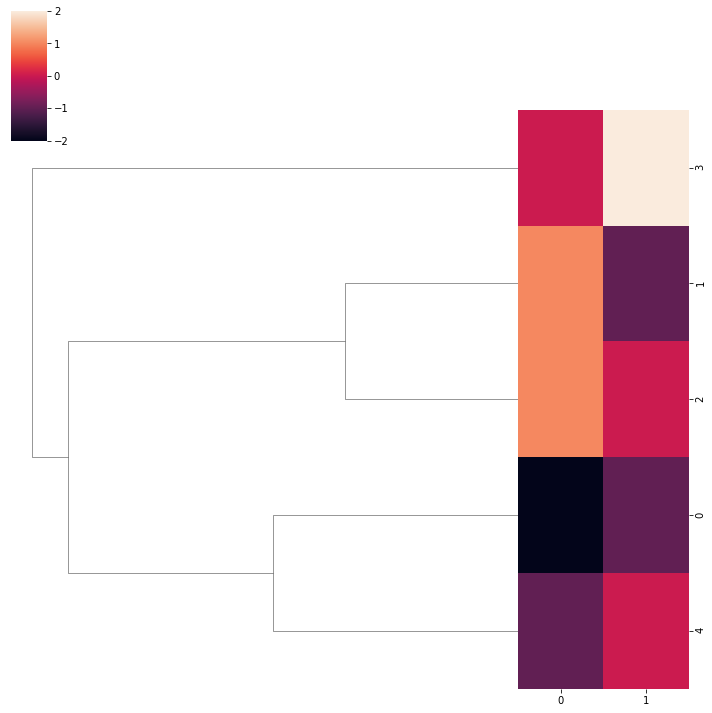

In [3]:
import seaborn as sns
sns.clustermap(X,col_cluster=False,dendrogram_ratio=(.75,.15));

The horizontal position in the dendrogram above indicates the linkage strength. Working from right to left, we see the creation of $C_1$ first, then $C_2$. These are merged into a single set before finally being merged with $\bfx_3$. (Note that the rows are reordered according to the values on the far right, in order to avoid having lines cross over one another.)

In effect, we get an entire family of clusterings, by stopping at any linkage value we want. If we chose to stop at value 1.5, for instance, we would have the three clusters we derived above. Or, if we predetermine that we want $k$ clusters, we can stop after $n-k$ merges. 

## Case study: Penguins

Let's try agglomerative clustering to discover the species of the penguins. First, let's recall how many of each species we have.

In [4]:
import seaborn as sns
penguins = sns.load_dataset("penguins").dropna()
X = penguins[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]]
print(penguins["species"].value_counts())

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64


Our first attempt is single linkage. Because 2-norm distances are involved, we will use standardization in a pipeline with the clustering method. After fitting, the `labels_` property of the cluster object is a vector of cluster assignments.

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

single = AgglomerativeClustering(n_clusters=3,linkage="single")
pipe = make_pipeline(StandardScaler(),single)
pipe.fit(X)
penguins["single"] = single.labels_       # cluster assignments
penguins.loc[::24,["species","single"]]   # print out some rows

,species,single
0,Adelie,0
29,Adelie,0
54,Adelie,0
78,Adelie,0
102,Adelie,0
126,Adelie,0
150,Adelie,0
174,Chinstrap,0
198,Chinstrap,0
222,Gentoo,2


It seems that Gentoo is associated with cluster number 2, but the situation with the other species is less clear. Here are the value counts:

In [6]:
print("single linkage results:")
print(penguins["single"].value_counts())

single linkage results:
0    213
2    119
1      1
Name: single, dtype: int64


Comparing these with the species counts, it seems that the clustering may have found the Gentoo cases perfectly. That would imply that the other ones are almost all lumped into cluster 0, however. Here is the adjusted Rand index.

In [7]:
from sklearn.metrics import adjusted_rand_score
ARI = adjusted_rand_score(penguins["species"],penguins["single"])
print(f"single linkage ARI: {ARI:.4f}")

single linkage ARI: 0.6506


Now let's try it with Ward linkage (the default).

In [8]:
ward = AgglomerativeClustering(n_clusters=3,linkage="ward")
pipe = make_pipeline(StandardScaler(),ward)
pipe.fit(X)
penguins["ward"] = ward.labels_

print("Ward linkage results:")
print(penguins["ward"].value_counts())

Ward linkage results:
1    157
0    119
2     57
Name: ward, dtype: int64


This result looks more promising. The ARI confirms that hunch:

In [9]:
ARI = adjusted_rand_score(penguins["species"],penguins["ward"])
print(f"Ward linkage ARI: {ARI:.4f}")

Ward linkage ARI: 0.9132


If we guess at the likely correspondence between the cluster numbers and the different species, then we can find the confusion matrix:

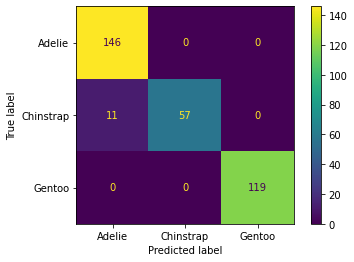

In [10]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
y = penguins["species"]
# Convert cluster numbers into labels:
y_hat = penguins["ward"].replace({1:"Adelie",0:"Gentoo",2:"Chinstrap"}) 

ConfusionMatrixDisplay(confusion_matrix(y,y_hat),display_labels=y.unique()).plot();